In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [ ]:
!unzip gdrive/MyDrive/cats_dogs.zip

Streaming output truncated to the last 5000 lines.
  inflating: dataset/training_set/cats/cat.37.jpg  
  inflating: dataset/training_set/cats/cat.370.jpg  
  inflating: dataset/training_set/cats/cat.3700.jpg  
  inflating: dataset/training_set/cats/cat.3701.jpg  
  inflating: dataset/training_set/cats/cat.3702.jpg  
  inflating: dataset/training_set/cats/cat.3703.jpg  
  inflating: dataset/training_set/cats/cat.3704.jpg  
  inflating: dataset/training_set/cats/cat.3705.jpg  
  inflating: dataset/training_set/cats/cat.3706.jpg  
  inflating: dataset/training_set/cats/cat.3707.jpg  
  inflating: dataset/training_set/cats/cat.3708.jpg  
  inflating: dataset/training_set/cats/cat.3709.jpg  
  inflating: dataset/training_set/cats/cat.371.jpg  
  inflating: dataset/training_set/cats/cat.3710.jpg  
  inflating: dataset/training_set/cats/cat.3711.jpg  
  inflating: dataset/training_set/cats/cat.3712.jpg  
  inflating: dataset/training_set/cats/cat.3713.jpg  
  inflating: dataset/training_set/c

In [ ]:
train_path="/content/dataset/test_set"
test_path="/content/dataset/training_set"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [ ]:
print(class_names)
print(class_names_test)

['cats', 'dogs']
['cats', 'dogs']


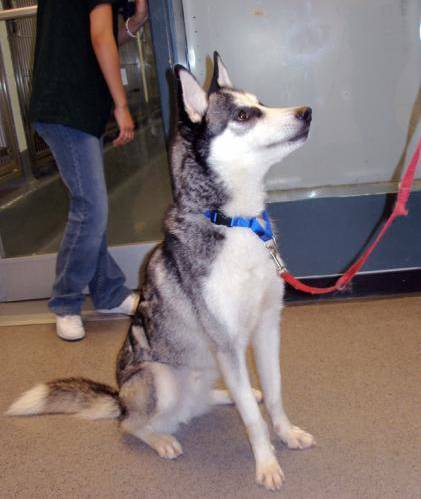

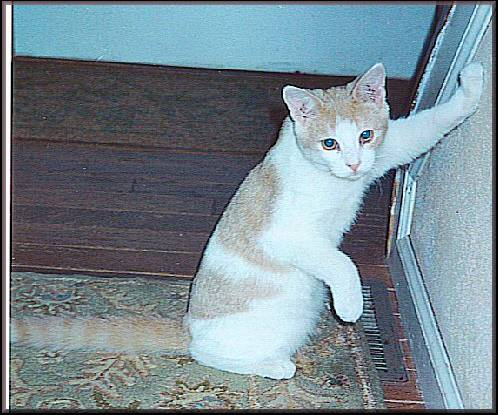

In [ ]:
image_dog=cv2.imread("/content/dataset/test_set/dogs/dog.4001.jpg")
cv2_imshow(image_dog)
image_cat=cv2.imread("/content/dataset/test_set/cats/cat.4001.jpg")
cv2_imshow(image_cat)

In [ ]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()

In [ ]:
train_generator = train_datagen.flow_from_directory("/content/dataset/training_set",target_size=(224, 224),batch_size=32,shuffle=True,class_mode='binary')
test_generator = test_datagen.flow_from_directory("/content/dataset/test_set",target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')

Found 8000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [ ]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [ ]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [ ]:
base_model = ResNet50(input_shape=(224, 224, 3))

In [ ]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [ ]:
model = Model(inputs=base_model.input, outputs=headModel)

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
base_model.load_weights("/content/gdrive/My Drive/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7fa20ec63b50> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7fa175799370> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa175799dc0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa175799d90> False
<keras.layers.core.activation.Activation object at 0x7fa175772b50> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7fa1756c0ca0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa1756fa910> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa1756c08e0> False
<keras.layers.core.activation.Activation object at 0x7fa1757726d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7fa17452d760> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fa1745243a0> False
<keras.layers.core.activation.Activation object at 0x7fa1756c0730> False
<keras.layers.convolutional

In [ ]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [ ]:
mc = ModelCheckpoint('/content/gdrive/My Drive/best_model.h5', monitor='val_accuracy', mode='auto')

In [ ]:
opt=SGD(lr=1e-4,momentum=0.9)
model.compile(loss="binary_crossentropy",optimizer=opt,metrics=["accuracy"])

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
H = model.fit_generator(train_generator,validation_data=test_generator,epochs=5,verbose=1,callbacks=[mc,es])

<ipython-input-22-6adb3769dd29>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(train_generator,validation_data=test_generator,epochs=10,verbose=1,callbacks=[mc,es])


Epoch 1/10
250/250 [==============================] - 135s 494ms/step - loss: 0.1819 - accuracy: 0.9224 - val_loss: 0.0864 - val_accuracy: 0.9675
Epoch 2/10
250/250 [==============================] - 122s 489ms/step - loss: 0.0985 - accuracy: 0.9613 - val_loss: 0.0820 - val_accuracy: 0.9705
Epoch 3/10
250/250 [==============================] - 124s 497ms/step - loss: 0.0826 - accuracy: 0.9659 - val_loss: 0.0761 - val_accuracy: 0.9745
Epoch 4/10
250/250 [==============================] - 123s 490ms/step - loss: 0.0739 - accuracy: 0.9693 - val_loss: 0.0706 - val_accuracy: 0.9755
Epoch 5/10
250/250 [==============================] - 125s 499ms/step - loss: 0.0657 - accuracy: 0.9753 - val_loss: 0.0780 - val_accuracy: 0.9735
Epoch 6/10
250/250 [==============================] - 119s 476ms/step - loss: 0.0601 - accuracy: 0.9758 - val_loss: 0.0727 - val_accuracy: 0.9735
Epoch 7/10
250/250 [==============================] - 121s 482ms/step - loss: 0.0572 - accuracy: 0.9790 - val_loss: 0.0729 -

In [ ]:
model.load_weights("/content/gdrive/My Drive/best_model.h5")

In [ ]:
model.evaluate_generator(test_generator)

In [ ]:
model_json = model.to_json()
with open("/content/gdrive/My Drive/model.json","w") as json_file:
  json_file.write(model_json)

In [ ]:
from keras.models import model_from_json

In [ ]:
 def predict_(image_path):
    #Load the Model from Json File
    json_file = open('/content/gdrive/My Drive/model.json', 'r')
    model_json_c = json_file.read()
    json_file.close()
    model_c = model_from_json(model_json_c)
    #Load the weights
    model_c.load_weights("/content/gdrive/My Drive/best_model.h5")
    #Compile the model
    opt = SGD(lr=1e-4, momentum=0.9)
    model_c.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    #load the image you want to classify
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224,224))
    cv2_imshow(image)
    #predict the image
    preds = model_c.predict(np.expand_dims(image, axis=0))[0]
    if preds==1:
        print("Predicted Label:Cat")
    else:
        print("Predicted Label: Dog")

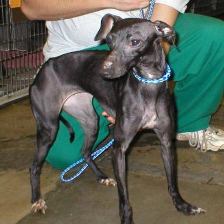

1/1 [==============================] - 2s 2s/step
Predicted Label: Dog


In [ ]:
predict_("/content/dataset/test_set/dogs/dog.4004.jpg")